In [4]:
run '../__init__.py'

In [5]:
import numpy as np
import networkx as nx
import cvxpy as cp

# import warnings
# warnings.filterwarnings("ignore")

## Networkx Simple Example

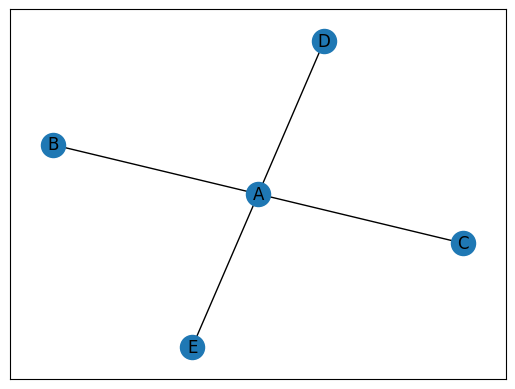

In [6]:
G = nx.Graph()

G.add_nodes_from(['A', 'B', 'C', 'D', 'E'])
edges = [('A', 'B'), ('A', 'C'), ('A', 'D'), ('A', 'E')]
for e in edges:
    G.add_edge(*e)
    
nx.draw_networkx(G)

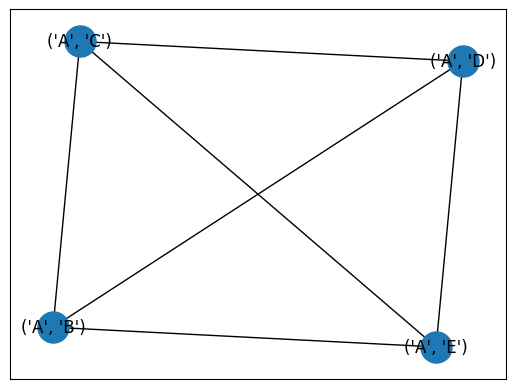

In [7]:
# Dual graph
G_prime=nx.line_graph(G)
nx.draw_networkx(G_prime, node_size=500)

In [8]:
L = nx.laplacian_matrix(G).todense()
L_prime = nx.laplacian_matrix(G_prime).todense()

In [9]:
L

array([[ 4, -1, -1, -1, -1],
       [-1,  1,  0,  0,  0],
       [-1,  0,  1,  0,  0],
       [-1,  0,  0,  1,  0],
       [-1,  0,  0,  0,  1]])

In [10]:
L_prime

array([[ 3, -1, -1, -1],
       [-1,  3, -1, -1],
       [-1, -1,  3, -1],
       [-1, -1, -1,  3]])

## CVXPY

Minimize $$||\bar{\Omega} \odot (\bar{F} - \bar{F_c})||_F^2 + ||\Omega \odot (F - F_c)||_F^2 + \lambda_1||\bar{F}L'F||_F + \lambda_2||FL'\bar{F}||_F + \lambda_3||\bar{F}(:, t+1) - \bar{F}(:, t)||_F + \lambda_4||F(:, t+1) - F(:, t)||_F + \lambda_5||\bar{F} - F||_F$$
s.t.
1. $F_c, \bar{F_c} > 0$
2. $F_c, \bar{F_c}$ contain integer elements
3. $P(t+1) = P(t) + \bar{F}(t) - F(t)$

In [11]:
# F_in: inflow [veh/t] at given road segments e and times t
F_in = np.array([[4, 8, 5],
                 [0, 0, 10],
                 [2, 0, 8],
                 [5, 2, 6]])

# F_out: outflow [veh/t] at given road segments e and times t
F_out = np.array([[3, 2, 2],
                  [5, 7, 1],
                  [5, 0, 3],
                  [0, 5, 4]])
print(F_in.shape)

(4, 3)


In [12]:
# Completed versions of F_in and F_out matrices, respectively.
F_in_c = cp.Variable((4, 3))
F_out_c = cp.Variable((4, 3))

In [13]:
# Net parking state matrix at time 0 (i.e., initial number of parked cars)
P0 = np.zeros((4, 1))

In [14]:
# Omegas are binary matrices (with the same dimensions as F_in and F_out, respectively) where each element indicates whether the corresponding element in F_in / F_out is known (1) or unknown (0).
omega_in = np.array([[1, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]])
omega_out = np.array([[1, 1, 1], [1, 1, 1], [1, 0, 1], [0, 1, 1]])

In [15]:
# Regularization parameters that controls the trade-off between fitting the known elements and promoting a low-rank structure.
l1, l2, l3, l4, l5 = 1, 1, 1, 1, 1


$$||\bar{\Omega} \odot (\bar{F} - \bar{F_c})||_F^2 + ||\Omega \odot (F - F_c)||_F^2$$

In [16]:
expr1 = cp.square(cp.atoms.norm(cp.multiply(omega_in, (F_in - F_in_c)), p='fro'))
expr2 = cp.square(cp.atoms.norm(cp.multiply(omega_out, (F_out - F_out_c)), p='fro'))

$$\lambda_1||\bar{F}^\intercal L'F||_F + \lambda_2||F^\intercal L'\bar{F}||_F$$

In [29]:
L_prime.shape

(4, 4)

In [18]:
expr3 = l1 * cp.atoms.norm(F_in.T @ L_prime @ F_out, p='fro')
expr4 = l2 * cp.atoms.norm(F_out.T @ L_prime @ F_in, p='fro')

$$\lambda_3||\bar{F}(:, t+1) - \bar{F}(:, t)||_F + \lambda_4||F(:, t+1) - F(:, t)||_F$$

In [19]:
expr5 = l3 * cp.atoms.norm(F_in[:, 1:] - F_in[:, :-1], p='fro')
expr6 = l4 * cp.atoms.norm(F_out[:, 1:] - F_out[:, :-1], p='fro')

$$\lambda_5||\bar{F} - F||_F$$

In [20]:
expr7 = l5 * cp.atoms.norm(F_in - F_out, p='fro')

1. $F_c, \bar{F_c} > 0$
2. $F_c, \bar{F_c}$ contain integer elements
3. $P(t+1) = P(t) + \bar{F}(t) - F(t)$

In [21]:
# Define the constraints
constraints = [
    F_in_c >= 0,  # Ensure each element of F_in_c is positive
    F_out_c >= 0,  # Ensure each element of F_out_c is positive
    # assert for Parking matrix to be positive
    P0 + cp.cumsum(F_in_c - F_out_c, axis=1) >= 0
]

Minimize

In [22]:
problem = cp.Problem(objective=cp.Minimize(expr1 + expr2 + expr3 + expr4 + expr5 + expr6 + expr7),
                     constraints=constraints)
problem.solve()

245.65732925649698

In [23]:
F_in

array([[ 4,  8,  5],
       [ 0,  0, 10],
       [ 2,  0,  8],
       [ 5,  2,  6]])

In [24]:
F_in_c.value

array([[ 3.99999765,  7.99999945,  4.9999996 ],
       [12.12728976,  8.00279417,  9.99999976],
       [ 3.49994858, 14.36597369,  7.99999975],
       [ 4.99999754,  1.99999738,  5.99999934]])

In [25]:
F_out_c.value

array([[3.00000098, 1.99999972, 1.99999964],
       [4.99999986, 6.99999987, 0.9999989 ],
       [3.49994858, 7.57691389, 2.99999979],
       [0.81255903, 5.00000112, 4.00000011]])

In [26]:
F_in_c.value - F_out_c.value

array([[ 9.99996665e-01,  5.99999973e+00,  2.99999996e+00],
       [ 7.12728990e+00,  1.00279431e+00,  9.00000086e+00],
       [ 3.18396864e-10,  6.78905980e+00,  4.99999996e+00],
       [ 4.18743851e+00, -3.00000373e+00,  1.99999923e+00]])

In [27]:
P0 + np.cumsum(F_in_c.value - F_out_c.value, axis=1)

array([[9.99996665e-01, 6.99999640e+00, 9.99999636e+00],
       [7.12728990e+00, 8.13008421e+00, 1.71300851e+01],
       [3.18396864e-10, 6.78905980e+00, 1.17890598e+01],
       [4.18743851e+00, 1.18743477e+00, 3.18743400e+00]])

In [28]:
np.concatenate([P0, np.round(P0 + np.cumsum(F_in_c.value - F_out_c.value, axis=1))], axis=1)

array([[ 0.,  1.,  7., 10.],
       [ 0.,  7.,  8., 17.],
       [ 0.,  0.,  7., 12.],
       [ 0.,  4.,  1.,  3.]])

In [30]:
problem = cp.Problem(objective=cp.Minimize(expr1 + expr2 + expr3 + expr4 + expr5 + expr6 + expr7),
                     constraints=constraints)
problem.solve()

245.65732925649698